# From Simple to Sophisticated: Enhancing Prompts with Metaprompting

Welcome to this cookbook on metaprompting! In this guide, we'll walk through the process of taking a basic prompt and refining it to improve the quality of outputs from a language model. We'll use the example of generating travel itineraries based on user preferences.


Metaprompting is the technique of iteratively refining prompts to get more accurate and detailed outputs from a language model. In this example, we'll start with a simple travel itinerary prompt and then enhance it to see how the outputs improve. We'll also evaluate these outputs systematically.

In [1]:
import pandas as pd
import openai 
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from pydantic import BaseModel

client = openai.Client()

## Importing the Data

First, we need a dataset of travel preferences. We generated 100 examples with the following fields:
- **Location**: Travel destination (e.g., Paris, Tokyo)
- **Duration**: Length of the trip (e.g., 3 days, 1 week)
- **Preferences**: Traveler's interests (e.g., art, local cuisine)


In [2]:
# Load the dataset
df = pd.read_csv('data/travel_itinerary_preferences_dataset.csv')

# Display the first few rows
df.head()

,Location,Duration,Preferences
0,Vancouver,5 days,"nature, cultural experiences, adventure"
1,San Francisco,1 week,"family-friendly, shopping, photography"
2,Tokyo,1 week,"shopping, relaxation"
3,Marrakech,1 week,"local cuisine, beach, adventure, relaxation"
4,San Francisco,3 days,"budget-friendly, adventure"


## Iterating on Prompts


Let's start with a simple prompt and then used the O1 model to enhance it for better results.

In [3]:
simple_prompt = "Create a {Duration} itinerary for {Location} focusing on {Preferences}."


To improve the prompt, we provided the O1 model with the context and goals we wanted to achieve. We asked it to generate a more detailed prompt that would produce richer and more complete itineraries.

In [4]:
metaprompt = """
Improve the following prompt to generate a more detailed travel itinerary:

{simple_prompt}

These are my evaluation criteria: 
    1. Relevance to Preferences
    2. Detail and Completeness
    3. Diversity of Activities
    4. Feasibility and Practicality
    5. Creativity and Uniqueness

Only return the prompt.
"""

In [5]:
def get_model_response(messages, model="o1-preview"):
    response = client.chat.completions.create(
        messages=messages,
        model=model,
    )
    return response.choices[0].message.content


complex_prompt = get_model_response([{"role": "user", "content": metaprompt.format(simple_prompt=simple_prompt)}])
complex_prompt

'Create a detailed and comprehensive {Duration} itinerary for {Location} focusing on {Preferences}. The itinerary should include a diverse range of activities that are highly relevant to your preferences. For each day, provide specific details such as activity descriptions, locations, timings, and any necessary travel information. Ensure the plan is feasible and practical by considering factors like operating hours and travel times between destinations. Additionally, incorporate creative and unique experiences that offer a distinctive perspective on {Location}.'

## Generating the Itineraries

For each entry in our dataset, we'll generate itineraries using both the simple and complex prompts.

In [6]:
def generate_resonse(prompt): 
    messages = [{"role": "user", "content": prompt}]
    response = get_model_response(messages, model="gpt-4o-mini")
    return response

def generate_itineraries(row):
    simple_itinerary = generate_resonse(simple_prompt.format(Duration=row['Duration'], Location=row['Location'], Preferences=row['Preferences']))
    complex_itinerary = generate_resonse(complex_prompt.format(Duration=row['Duration'], Location=row['Location'], Preferences=row['Preferences']))
    return simple_itinerary, complex_itinerary

In [7]:
# Add new columns to the dataframe for storing itineraries
df['Simple_Itinerary'] = None
df['Complex_Itinerary'] = None

# Use ThreadPoolExecutor to generate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(generate_itineraries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating Itineraries"):
        index = futures[future]
        simple_itinerary, complex_itinerary = future.result()
        df.at[index, 'Simple_Itinerary'] = simple_itinerary
        df.at[index, 'Complex_Itinerary'] = complex_itinerary

df.head()

Generating Itineraries: 100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


,Location,Duration,Preferences,Simple_Itinerary,Complex_Itinerary
0,Vancouver,5 days,"nature, cultural experiences, adventure","Sure! Here’s a 5-day itinerary for Vancouver, ...","## 5-Day Itinerary for Nature, Culture, and Ad..."
1,San Francisco,1 week,"family-friendly, shopping, photography",Here's a one-week itinerary for a family-frien...,### One-Week Family-Friendly Itinerary for San...
2,Tokyo,1 week,"shopping, relaxation",Here's a 1-week itinerary for Tokyo that focus...,Here’s a comprehensive one-week itinerary for ...
3,Marrakech,1 week,"local cuisine, beach, adventure, relaxation",### 1-Week Itinerary for Marrakech: Focus on L...,### One-Week Itinerary for Marrakech\n\n#### O...
4,San Francisco,3 days,"budget-friendly, adventure",Certainly! Here’s a 3-day budget-friendly adve...,### 3-Day Budget-Friendly Adventure Itinerary ...


## Evaluating the Results

To check the difference in performance between the 2 prompts, we'll use a structured evaluation approach with the LLM acting as a judge. Here's the prompt we'll use for evaluation:

In [8]:
evaluation_prompt = """
You are an expert travel planner tasked with rigorously evaluating a travel itinerary based on specific criteria. Below is the itinerary to be evaluated:

{itinerary}

Please evaluate the itinerary based on the following criteria, using a scale of 1 to 5 (1 being the lowest and 5 being the highest). Reserve a score of 5 for truly exceptional performance that goes above and beyond typical expectations:

1. **Relevance to Preferences**: Does the itinerary closely match the stated traveler preferences without including irrelevant activities?  
2. **Detail and Completeness**: Is the itinerary comprehensive and detailed, including specific activities, exact timings, meal plans, and logistics? Are there any gaps?  
3. **Diversity of Activities**: Does the itinerary offer a well-balanced and varied mix of activities? Is it lacking in variety in any areas?  
4. **Feasibility and Practicality**: Is the itinerary realistic and achievable, considering travel times, activity durations, and rest periods? Are there any logistical challenges?  
5. **Creativity and Uniqueness**: Does the itinerary include unique, off-the-beaten-path experiences that are not commonly found in standard travel plans?  

For each criterion, provide a score from 1 to 5 and a brief justification for the scores. Be critical in your evaluation and only award high scores for exceptional quality.
"""

class ScoreCard(BaseModel):
    relevance_to_preferences: int
    detail_and_completeness: int
    diversity_of_activities: int
    feasibility_and_practicality: int
    creativity_and_uniqueness: int
    justification: str

Small note, you can actually meta-prompt your evaluation prompt as well! 

In [9]:
def evaluate_itineraries(row):
    simple_messages = [{"role": "user", "content": evaluation_prompt.format(itinerary=row['Simple_Itinerary'])}]
    complex_messages = [{"role": "user", "content": evaluation_prompt.format(itinerary=row['Complex_Itinerary'])}]
    
    simple_itinerary = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=simple_messages,
        response_format=ScoreCard)
    simple_itinerary = simple_itinerary.choices[0].message.parsed
    
    complex_itinerary = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=complex_messages,
        response_format=ScoreCard)
    complex_itinerary = complex_itinerary.choices[0].message.parsed
    
    return simple_itinerary, complex_itinerary

# Add new columns to the dataframe for storing evaluations
df['Simple_Evaluation'] = None
df['Complex_Evaluation'] = None

# Use ThreadPoolExecutor to evaluate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(evaluate_itineraries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating Itineraries"):
        index = futures[future]
        simple_itinerary, complex_itinerary = future.result()
        df.at[index, 'Simple_Evaluation'] = simple_itinerary
        df.at[index, 'Complex_Evaluation'] = complex_itinerary

df.head()

Evaluating Itineraries:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating Itineraries: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


,Location,Duration,Preferences,Simple_Itinerary,Complex_Itinerary,Simple_Evaluation,Complex_Evaluation
0,Vancouver,5 days,"nature, cultural experiences, adventure","Sure! Here’s a 5-day itinerary for Vancouver, ...","## 5-Day Itinerary for Nature, Culture, and Ad...",relevance_to_preferences=5 detail_and_complete...,relevance_to_preferences=5 detail_and_complete...
1,San Francisco,1 week,"family-friendly, shopping, photography",Here's a one-week itinerary for a family-frien...,### One-Week Family-Friendly Itinerary for San...,relevance_to_preferences=5 detail_and_complete...,relevance_to_preferences=5 detail_and_complete...
2,Tokyo,1 week,"shopping, relaxation",Here's a 1-week itinerary for Tokyo that focus...,Here’s a comprehensive one-week itinerary for ...,relevance_to_preferences=5 detail_and_complete...,relevance_to_preferences=4 detail_and_complete...
3,Marrakech,1 week,"local cuisine, beach, adventure, relaxation",### 1-Week Itinerary for Marrakech: Focus on L...,### One-Week Itinerary for Marrakech\n\n#### O...,relevance_to_preferences=5 detail_and_complete...,relevance_to_preferences=5 detail_and_complete...
4,San Francisco,3 days,"budget-friendly, adventure",Certainly! Here’s a 3-day budget-friendly adve...,### 3-Day Budget-Friendly Adventure Itinerary ...,relevance_to_preferences=4 detail_and_complete...,relevance_to_preferences=5 detail_and_complete...


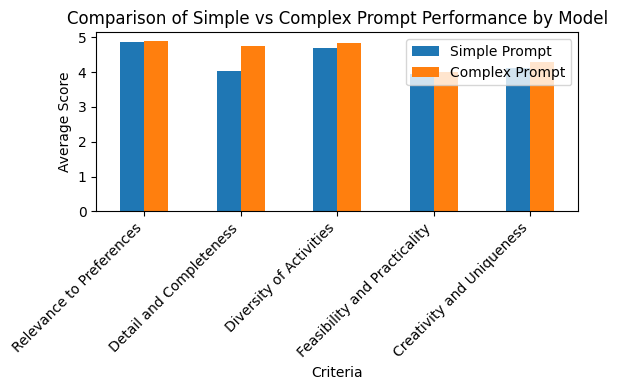

In [10]:
import matplotlib.pyplot as plt

df["Simple_Scores"] = df["Simple_Evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])
df["Complex_Scores"] = df["Complex_Evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])


# Calculate average scores for each criterion
criteria = [
    'Relevance to Preferences',
    'Detail and Completeness',
    'Diversity of Activities',
    'Feasibility and Practicality',
    'Creativity and Uniqueness'
]

# Calculate average scores for each criterion by model
simple_avg_scores = df['Simple_Scores'].apply(pd.Series).mean()
complex_avg_scores = df['Complex_Scores'].apply(pd.Series).mean()


# Prepare data for plotting
avg_scores_df = pd.DataFrame({
    'Criteria': criteria,
    'Simple Prompt': simple_avg_scores,
    'Complex Prompt': complex_avg_scores
})

# Plotting
avg_scores_df.plot(x='Criteria', kind='bar', figsize=(6, 4))
plt.ylabel('Average Score')
plt.title('Comparison of Simple vs Complex Prompt Performance by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The basic prompt performed well in terms of relevance and diversity, but the complex prompt notably enhanced the completeness and creativity of the itineraries. However, it's worth noting that this is a simplified example, and the benefits of refining prompts are expected to be even more pronounced in real-world, production-level applications.

## Conclusion

By refining our prompts, we can enhance the quality of outputs from a language model. This example demonstrates how adding detail and structure to a prompt leads to more relevant, complete, and creative results. Even though the differences here are small, Metaprompting is a powerful technique that developers can use to build more effective and user-centric applications.